Epoch [20/100], Loss: 17504.6152
Epoch [40/100], Loss: 6200.2705
Epoch [60/100], Loss: 4343.9326
Epoch [80/100], Loss: 3664.1245
Epoch [100/100], Loss: 3037.3457


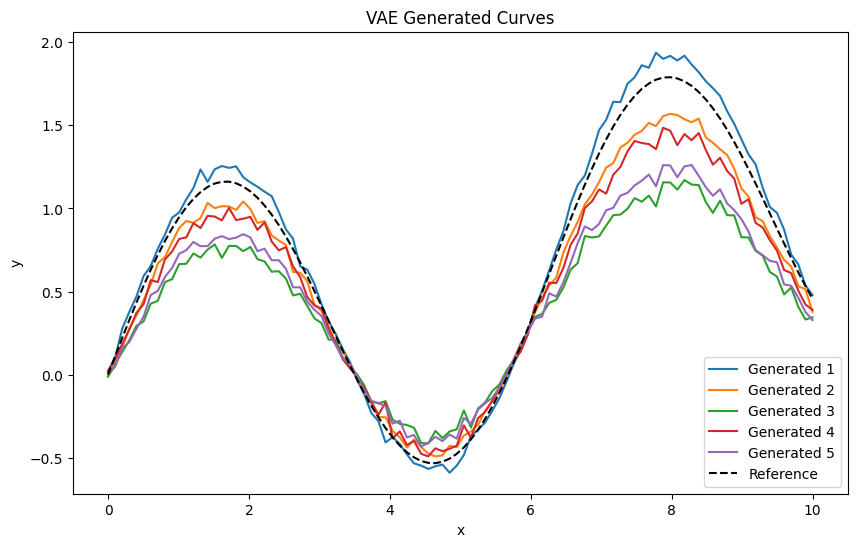

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 1. 生成训练数据（无噪声的干净数据）
def generate_data(n_points=100, n_samples=1000):
    x = torch.linspace(0, 10, n_points)
    data = []
    for _ in range(n_samples):
        scale = torch.rand(1) * 0.5 + 0.75  # 幅度随机变化 [0.75, 1.25]
        shift = torch.rand(1) * 0.2 - 0.1   # 轻微垂直偏移 [-0.1, 0.1]
        y = scale * torch.sin(x) + 0.1 * x + shift
        data.append(y)
    return torch.stack(data)  # (n_samples, n_points)

# 2. 定义 VAE 模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# 3. VAE 损失函数
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# 4. 训练 VAE
def train_vae(data, input_dim, hidden_dim=128, latent_dim=8, epochs=100):
    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_data, mu, logvar = model(data)
        loss = vae_loss(recon_data, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model

# 5. 生成新数据并可视化
def generate_and_plot(model, n_points, n_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.fc_mu.out_features)
        generated_data = model.decode(z)
    
    x = np.linspace(0, 10, n_points)
    plt.figure(figsize=(10, 6))
    for i in range(n_samples):
        plt.plot(x, generated_data[i].numpy(), label=f'Generated {i+1}')
    x_tensor = torch.tensor(x, dtype=torch.float32)
    reference = torch.sin(x_tensor) + 0.1 * x_tensor
    plt.plot(x, reference.numpy(), 'k--', label='Reference')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('VAE Generated Curves')
    plt.show()

# 主程序
def main():
    n_points = 100
    n_samples = 1000
    
    data = generate_data(n_points, n_samples)
    vae = train_vae(data, input_dim=n_points)
    generate_and_plot(vae, n_points)

if __name__ == "__main__":
    main()